This notebook aims to estimate the sample size required for the AICO test to attain a certain power under a given significance level. In other words, we seek to answer the question: how many samples are needed to reliably identify significant variables? The short answer is that it depends on the desired power and the characteristics of each feature, but a sample size of around 10,000 should suffice for most cases.

For a detailed answer, we begin with a quick review of the AICO test theoretical setup. Suppose we have testing data with *n* observations. The AICO test evaluates whether a particular feature $X_k$, or a pair of features $(X_k, X_j)$, is significant by constructing the corresponding $\Delta$. Based on the derived *n* samples of $\Delta$, we perform the sign-test with the following hypotheses:
* Null Hypothesis ($H_0$): median($\Delta$) = 0
* Alternative Hypothesis ($H_1$): median($\Delta$) > 0

A particular feature $X_k$ is considered significant when $H_0$ is rejected in favor of $H_1$. By definition, *power* is the probability of rejecting $H_0$ when $H_1$ is actually true, based on a sample of size *n*. However, since there are many possible distributions under the alternative hypothesis, there is no common *power* across all such distributions. Therefore, we consider the *power function* that returns the power of the test under each possible subset of the alternative hypothesis distributions. One way to parameterize the *power function* is with the probability of $\Delta$ being greater than zero: $p = P(\Delta > 0)$. Under certain technical conditions, $H_1$ is simply the collection of distributions with $p > 0.5$, and all distributions with the same $p$ will have the same power, given a particular sample size *n*.

Mathematically, the *power function* maps the sample size *n*, significance level $\alpha$, and parameter $p = P(\Delta > 0)$ to the *power*. Thus, our goal is to find *n* such that the *power* is at least a desired level for given $\alpha$ and $p$. While $\alpha = 0.05$ or $0.01$ is suggested by convention, we might need to estimate $p$ based on the data. One method to estimate $p$ is the relative empirical frequency, the proportion of $\Delta > 0$, which is also implemented in the Result Visualization in the AICO codes.

The following code visualizes the estimated required sample size *n* based on three methods: binomial exact, uniformly-most-powerful (UMP) binomial exact, and normal approximation.

**Technical Note:** Briefly, the binomial exact method corresponds to the current implementation of the sign-test in the AICO code, where we either certainly reject $H_0$ or not reject $H_1$ depending on whether the test statistics exceed the threshold. This implementation could be refined to maximize the power by introducing random rejection when the test statistics are exactly at the threshold. The corresponding power can be computed with the UMP binomial exact method. Despite some minor discrepancies when the sample size is small, both the binomial exact and UMP binomial exact methods are very similar when the sample size is sufficiently large (which is often the case in practice) and can be approximated with the normal approximation method.

---

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom, norm

from aico.plot import set_fig


def compute_n_approx(alpha, power, p):
    '''Compute required sample size N for sign-test (alternative = greather)
    with significance level = sig and the given power 
    under alternative hypothesis that P(X > 0) = p
    '''
    return np.ceil((norm.ppf(1 - alpha) + norm.ppf(power))**2 / (4 * (p - 0.5)**2))


def compute_power_exact(n, alpha, p, ump=False):
    '''Compute power of sign-test (alternative = greater)
    with significance level = sig and sample size
    under alternative hypothesis that P(X > 0) = p
    '''
    ppf = binom.ppf(1 - alpha, n, 0.5)
    power = binom.sf(ppf, n, p)
    if ump:
        power += binom.pmf(ppf, n, p) * (binom.cdf(ppf, n, 0.5) - (1 - alpha)) / binom.pmf(ppf, n, 0.5)
    power_df = pd.DataFrame(dict(n=[n],
                                 p=[p],
                                 ppf=[ppf],
                                 power=[power]))
    power_df = power_df.sort_values(by='power')
    return power_df


def compute_n_exact_each(sig, power, p, ump=False):
    '''Compute the smallest sample size N 
    such that sign-test power is at least the given power
    Since power is non-monotonic for non-ump test (due to the discreteness), linear search is required
    '''
    assert(power < 1)
    n = 0
    while True:
        power_n = compute_power_exact(n, sig, p, ump)['power'][0]
        if power_n >= power:
            return n
        n += 1

def compute_n_exact(alpha, power, p, ump=False):
    '''Helper function to compute n_exact across all power or p
    '''
    if type(p) is np.ndarray:
        n = np.vectorize(lambda p_i: compute_n_exact_each(alpha, power, p_i, ump))(p)
    elif type(power) is np.ndarray:
        n = np.vectorize(lambda power_i: compute_n_exact_each(alpha, power_i, p, ump))(power)
    else:
        n = compute_n_exact_each(alpha, power, p, ump)
    return n


def plot_power_all_methods(p_list, power_list, alpha=0.05):
    num_plot = len(p_list)
    figs = set_fig(2, f'Sign-Test Power Analysis | Null: Median(Delta) = 0 | Alternative: Larger | Significance Level = {alpha}')

    # For each fixed p = P(Delta > 0)
    axs = figs[0].subplots(num_plot, 1)
    figs[0].suptitle('[For each fixed P(Delta > 0)]')
    for i in range(num_plot):
        ax = axs[i]
        p = p_list[i]
        computed_n_list = compute_n_approx(alpha, power_list, p)
        ax.plot(power_list, computed_n_list, 'o-', label='Normal Approximation')
        
        computed_n_list_exact = compute_n_exact(alpha, power_list, p)
        ax.plot(power_list, computed_n_list_exact, 'o-', label='Binomial Exact')

        computed_n_list_exact_ump = compute_n_exact(alpha, power_list, p, ump=True)
        ax.plot(power_list, computed_n_list_exact_ump, 'o-', label='Binomial Exact (UMP)')
        
        ax.set_xlabel('Power')
        ax.set_ylabel('Sample Size')
        ax.set_title(f'P(Delta > 0) = {p}')
        ax.set_xticks(power_list)
        ax.legend()

    # For each fixed power
    axs = figs[1].subplots(num_plot, 1)
    figs[1].suptitle('[For each fixed power]')
    for i in range(num_plot):
        ax = axs[i]
        power = power_list[i]
        computed_n_list = compute_n_approx(alpha, power, p_list)
        ax.plot(p_list, computed_n_list, 'o-', label='Normal Approximation')

        computed_n_list_exact = compute_n_exact(alpha, power, p_list)
        ax.plot(p_list, computed_n_list_exact, 'o-', label='Binomial Exact')

        computed_n_list_exact_ump = compute_n_exact(alpha, power, p_list, ump=True)
        ax.plot(p_list, computed_n_list_exact_ump, 'o-', label='Binomial Exact (UMP)')

        ax.set_xlabel('P(Delta > 0)')
        ax.set_ylabel('Sample Size')
        ax.set_title(f'Power = {power}')
        ax.set_xticks(p_list)
        ax.set_yscale('log')
        ax.legend()

    plt.show()


def plot_power_ump(p_list, power_list, alpha):
    # Focus on UMP-Binomial Power
    plt.figure(figsize=(12, 8))
    for p in p_list:
        computed_n_list_exact_ump = compute_n_exact(alpha, power_list, p, ump=True)
        plt.plot(power_list, computed_n_list_exact_ump, 'o-', label=f'p={p}')
        
    plt.xlabel('Power')
    plt.ylabel('Sample Size')
    plt.title('\n'.join(['Sign-Test Power Analysis',
                        f'Null: Median(Delta) = 0 | Alternative: Larger | Significance Level = {alpha} | Method = Binomial Exact (UMP)']))
    plt.xticks(power_list)
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()

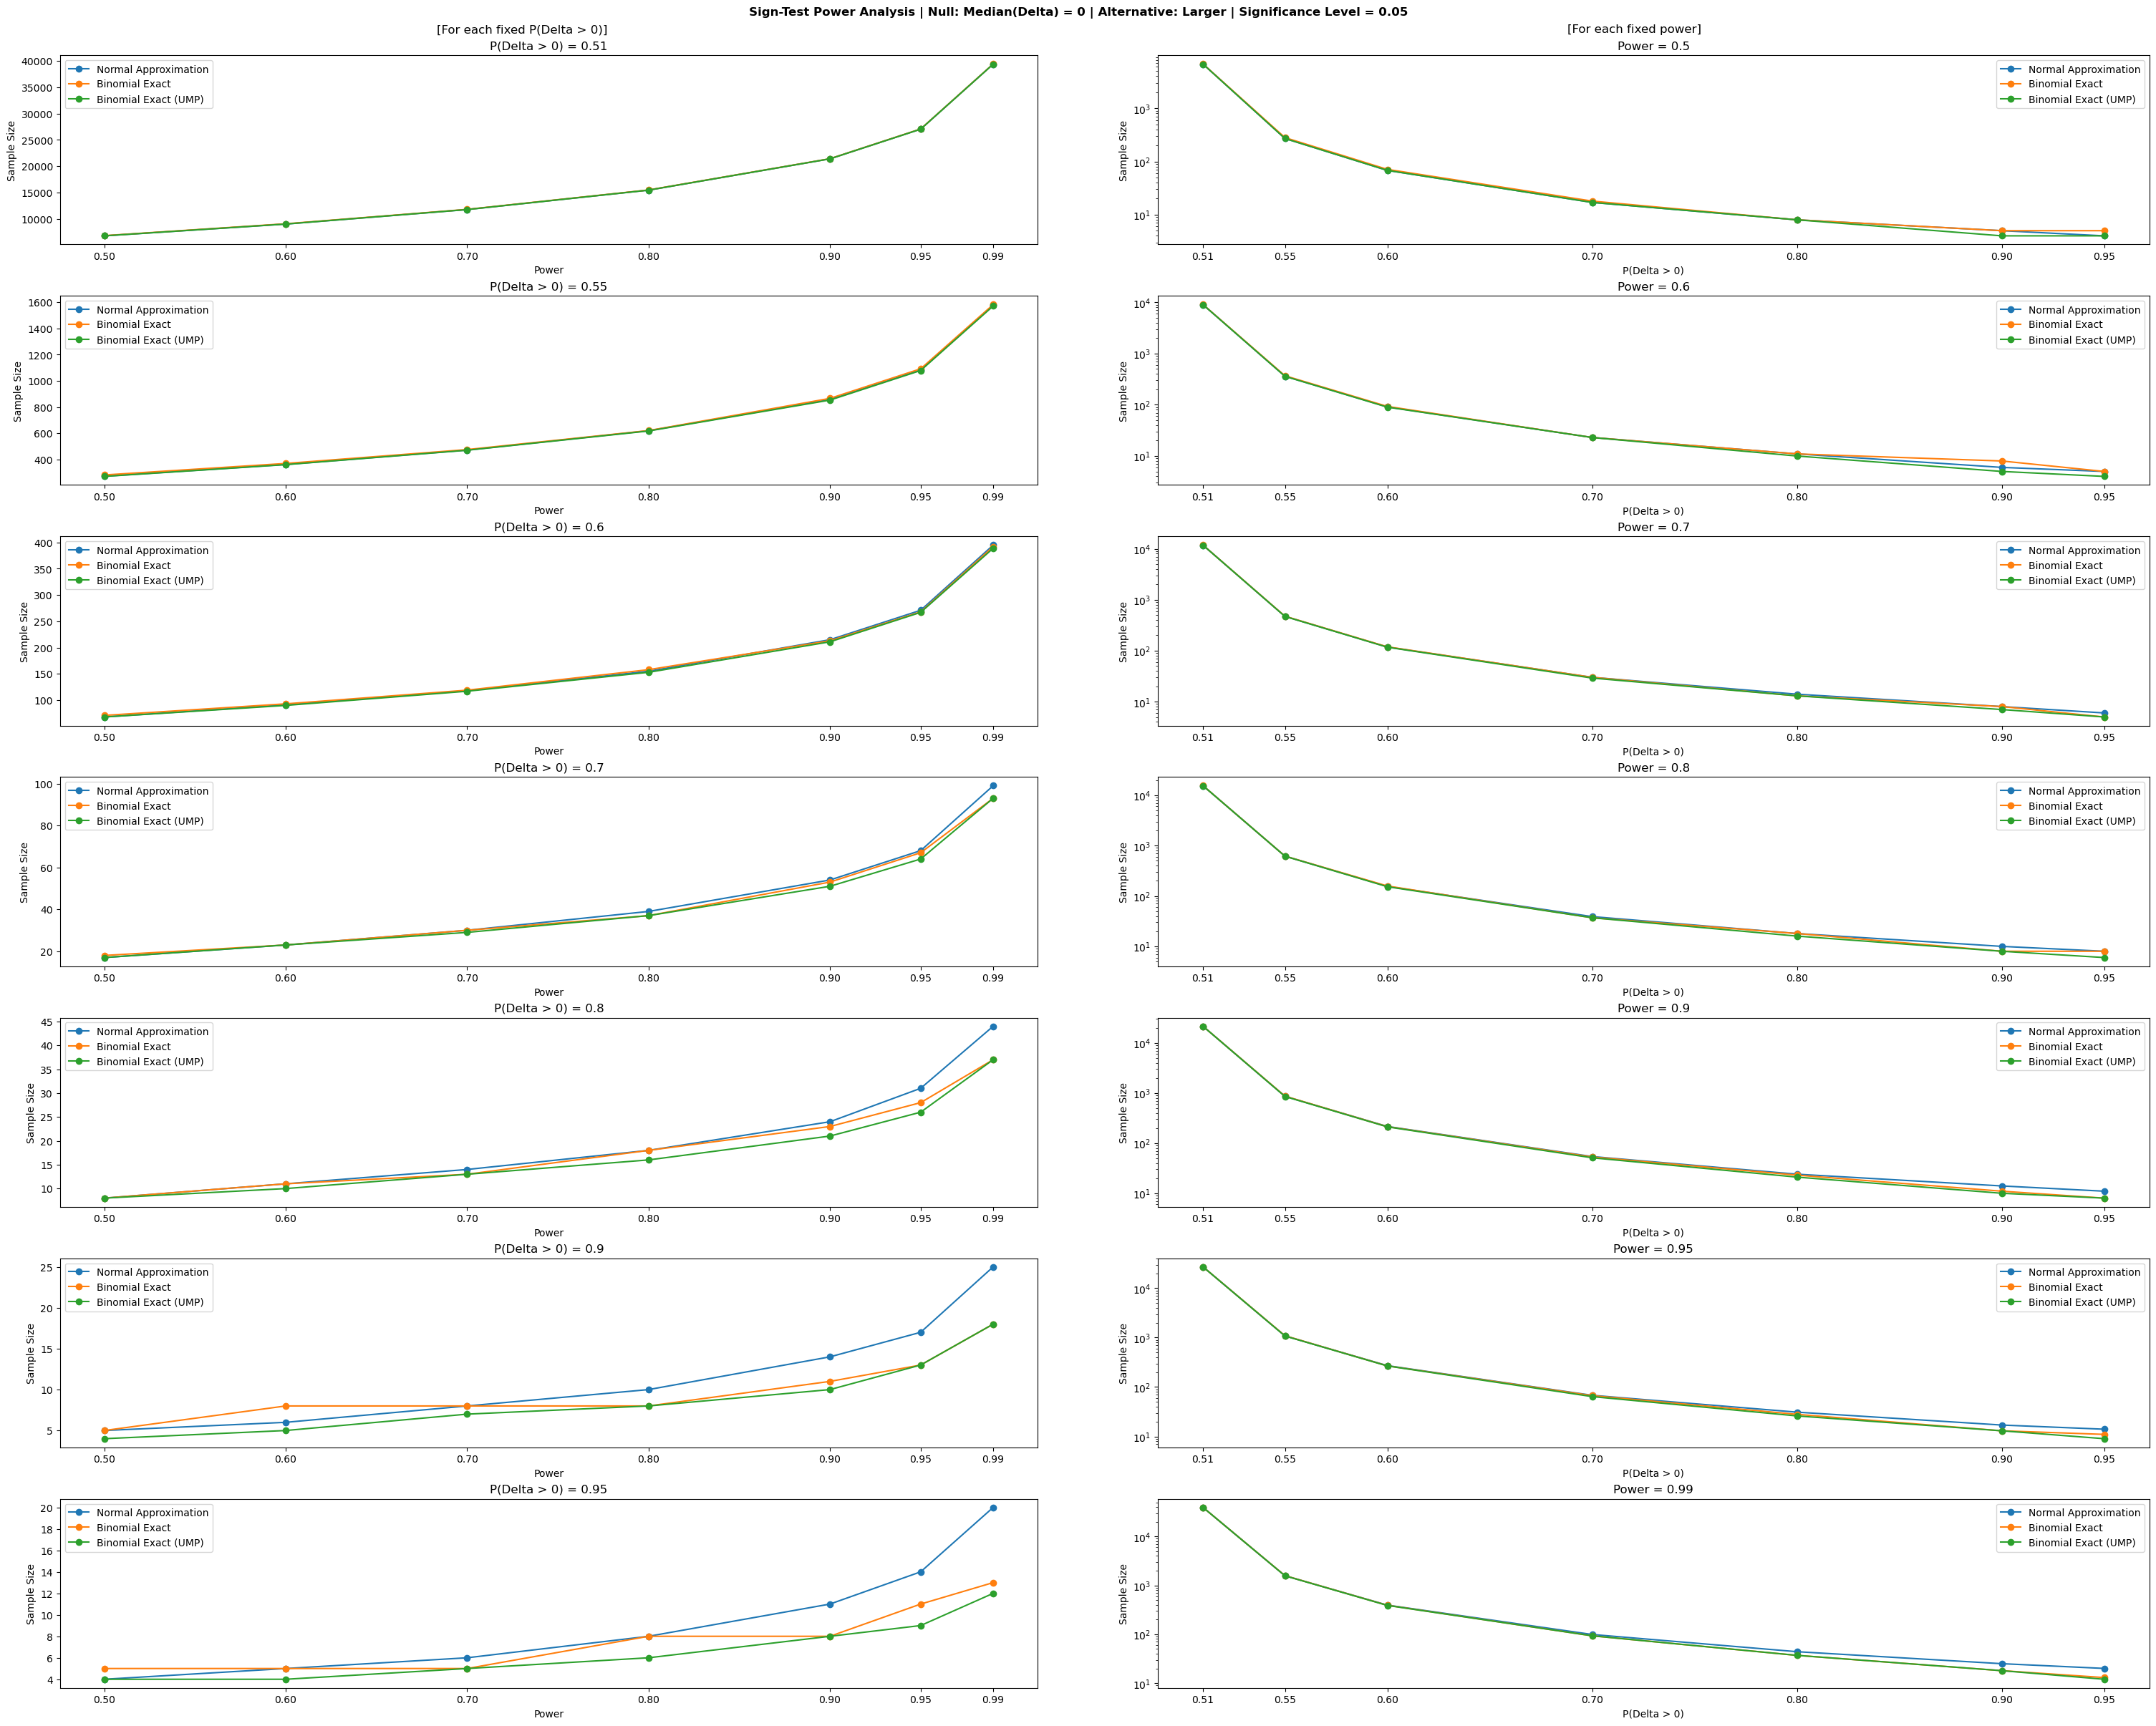

In [9]:
p_list = np.array([0.51, 0.55, 0.6, 0.7, 0.8, 0.9, 0.95])
power_list = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
alpha = 0.05

plot_power_all_methods(p_list, power_list, alpha)

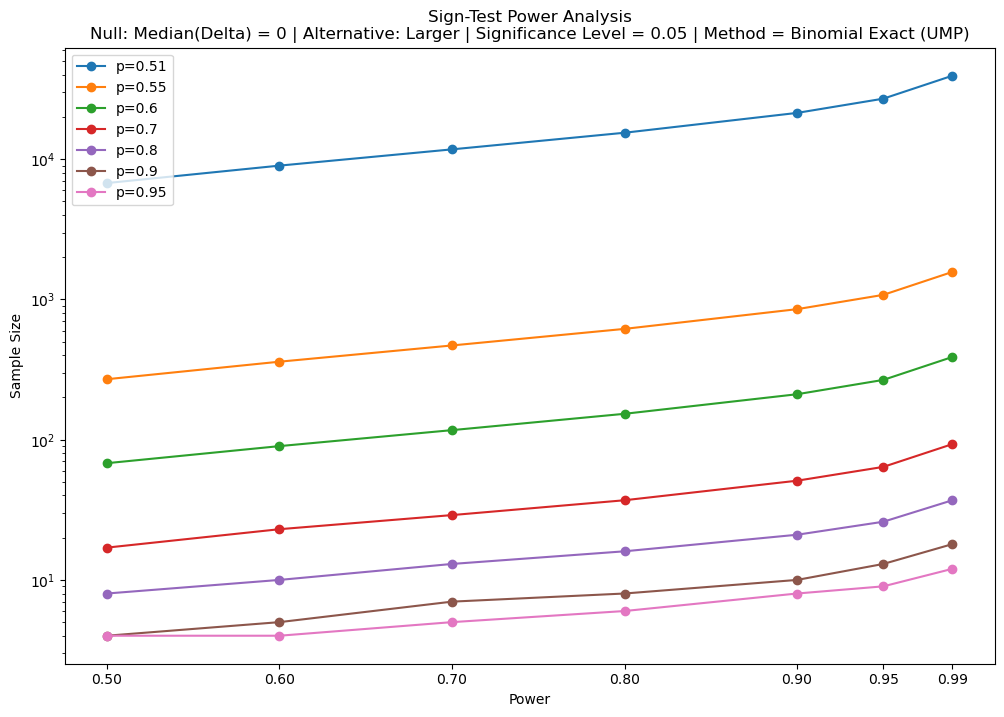

In [12]:
plot_power_ump(p_list, power_list, alpha)